In [1]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import os
import numpy as np
import math
import time

### Defining the log odds
And those same odds to probability

In [2]:
# Both pxz and ltx_old(t-1) should be inputed as probabilities
def log_odds(pxz, ltx_old):
    p_x = 0.5
    log_odds = (math.log(pxz / (1 - pxz)) -  math.log(p_x / (1 - p_x)) + ltx_old)
    
    return log_odds

def odds_to_probability(log_odd):
    if log_odd > 0:
        bel_x = 1 / (1 + np.exp(-log_odd))
    else:
        bel_x = np.exp(log_odd) / (1 + np.exp(log_odd))
    return bel_x

def odds_to_probability_array(log_odds_array):
    vectorized_odds_to_probability = np.vectorize(odds_to_probability)
    return vectorized_odds_to_probability(log_odds_array)

def probability_to_odds(ltx_prob):
    log_odd = math.log(ltx_prob / (1 - ltx_prob))
    return log_odd
    


print(log_odds(0.01, 0.1))
print(odds_to_probability(-0.2))

-4.49511985013459
0.4501660026875221


# Defining the transformations

## Robot to world
From robot to world(that is centered at the midle of the 3D map)

In [3]:
def make_transformation_robot_to_world(robot_handle, points):  
    robot_position = sim.getObjectPosition(robot_handle)
    robot_orientation = sim.getObjectOrientation(robot_handle)
    
    x_robot = robot_position[0]
    y_robot = robot_position[1]
    phi_rotation = robot_orientation[2] 

    x_points = points[:, 0]
    y_points = points[:, 1]
    
    transformation_matrix = np.array([
        [math.cos(phi_rotation), -math.sin(phi_rotation), x_robot],
        [math.sin(phi_rotation), math.cos(phi_rotation), y_robot],
        [0, 0, 1]])

    points_in_robot = np.ones((np.shape(points)[0], 3))
    
    points_in_robot[:, 0] = x_points
    points_in_robot[:, 1] = y_points

    x_ = transformation_matrix @ np.transpose(points_in_robot)

    transformed = np.transpose(np.delete(x_, 2, 0))
    
    return transformed

## World to robot
From the world, to the robot coordinates

In [4]:
def make_transformation_world_to_robot(robot_handle, points):
    robot_position = sim.getObjectPosition(robot_handle)
    robot_orientation = sim.getObjectOrientation(robot_handle)
    
    x_robot = robot_position[0]
    y_robot = robot_position[1]
    phi_rotation = robot_orientation[2] 

    x_points = points[:, 0]
    y_points = points[:, 1]
    
    transformation_matrix = np.array([
        [math.cos(phi_rotation), math.sin(phi_rotation), -x_robot],
        [-math.sin(phi_rotation), math.cos(phi_rotation), -y_robot],
        [0, 0, 1]])

    points_in_robot = np.ones((np.shape(points)[0], 3))

    points_in_robot[:, 0] = x_points
    points_in_robot[:, 1] = y_points

    x_ = transformation_matrix @ np.transpose(points_in_robot)

    transformed = np.transpose(np.delete(x_, 2, 0))
    
    return transformed

# Processing sensor data

## Sensor data translation
Transforms the data from the sensor into points in the coordinate system of the robot 

In [5]:
# Return all coordinates, in the robot Cord. system, that the laser
# would've "stopped" at. And it Returns a list, with the same number
# of coordinate points as the list of points detected by the laser, with
# 0s and 1s representing if that point was detected because it possibly 
# hit a object(0), or if its just the max range of the laser(1). 

# The max range can be changed at off_limit_range var.

def sensor_processing_to_robot_coordinates():
    # Declare noise variables levels.
    # 0 if not needed 
    noise_distance = 0.01
    noise_angle = 0.01
    # Change laser limit.
    off_limit_range = 4.8
    too_close_range = 0.22

    while(sim.getStringSignal("hokuyo_range_data") == None):
        sim.getStringSignal("hokuyo_range_data")

    string_range_data = sim.getStringSignal("hokuyo_range_data")
    string_angle_data = sim.getStringSignal("hokuyo_angle_data")
        
    raw_range_data = sim.unpackFloatTable(string_range_data) 
    raw_angle_data = sim.unpackFloatTable(string_angle_data) 
    
    # Add noise if noise variables are greater than 0
    if noise_distance > 0:
        raw_range_data = [dist + np.random.normal(0, noise_distance) for dist in raw_range_data]
    if noise_angle > 0:
        raw_angle_data = [angle + np.random.normal(0, noise_angle) for angle in raw_angle_data]

    radians = np.array(raw_angle_data)
    dist = np.array(raw_range_data)

    points = []

    off_limit_cells = []
    
    for i in range(0, len(radians)):
        if dist[i] > off_limit_range:
            off_limit_cells.append(1)
        elif dist[i] < too_close_range:
            off_limit_cells.append(2)
        else:
            off_limit_cells.append(0)
        points.append(np.array([math.cos(radians[i]) * dist[i], math.sin(radians[i]) * dist[i]]))

    points = np.array(points)

    return points, off_limit_cells

### Translated points to world coodinates
Transforms the points gotten from the data and in the robot coordinates into the world coordinates.

In [6]:
def sensor_data_to_world(robot_handle):
    sensor_data, off_limit = sensor_processing_to_robot_coordinates()
    return make_transformation_robot_to_world(robot_handle, sensor_data), off_limit

# Occupancy Grid
And some algorithms to know where to explore with the robot

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.draw import line
import scipy.ndimage as ndimage
import heapq

### Inverse sensor model
In the case of the laser, all points in the line (sensor - object detected by laser) should be marked as not occupied, with careful consideration of the last ones, closer to the detected object, as it could interfere with the already occupied ones, that is, the last point of a line is still in the line, so we sould remove it from the cells considered unoccupied.

In [8]:
def find_unoccupied_cells(translated_occupied_cells, trans_sensor_xy):
    occupied_cells = translated_occupied_cells.astype(np.int16)
    sensor_cell = trans_sensor_xy.astype(np.int16)

    unoccupied_cells = sensor_cell

    for cell in occupied_cells:
        unocc_cells_x, unocc_cells_y = line(sensor_cell[0], sensor_cell[1], cell[0], cell[1])

        unocc_cells = np.column_stack((unocc_cells_x, unocc_cells_y))

        # Remove the cell closest to the object detected.
        unocc_cells = np.delete(unocc_cells, -1, 0)

        unoccupied_cells = np.row_stack((unoccupied_cells, unocc_cells))
    
    return list(unoccupied_cells)

## Grid operations

### Reduced grid 
Apply a ternary/tri-branch-logic funtion to the grid to obtain a numpy array with 0s(unoccupied), 1s(occupied) and 2s(unknown).

In [9]:
def reduce_grid(grid):
    transformed_grid = np.zeros_like(grid, dtype=np.uint8)
    
    for i in range(0, len(transformed_grid[::1])):
        for j in range(0, len(transformed_grid[i, ::1])):
            if grid[i][j] < -0.2:
                transformed_grid[i][j] = 0
                
            elif grid[i][j] > 0:
                transformed_grid[i][j] = 1
                
            else:
                transformed_grid[i][j] = 2

    return transformed_grid

example_grid = np.array(
[[ 2.36, 3.00,  2.13,  1.12, 6.00,  2.58, 1.88,  3.58,  1.31, 8.00],
 [ 3.00, -0.99, -3.68, -3.16, -0.54, -3.43, 2.91, -1.25, -1.92, 7.00],
 [ 5.00, -3.90, -0.98, -3.12, -1.75,  -2.87, -1.11, -0.12, -1.85, 1.85],
 [ 5.00, -3.30, -0.28, -6, -2.12, 0.07, -1.64, 3.77, 1.61, 3.72],
 [ 3.62, -1.50, -0.92, -3.13, -3.84, -1.65, 2.30, -0.12, -0.91, 0.89],
 [ 1.22, 0.00, 0.00,  2.78,  1.64,  0,  1.06, -1.81,  3.69,  0.95],
 [ 3.20, 0.00, 0.00,  0.00,  2.38,  0,  0.1,  2.95, -1.98,  1.10],
 [0, 0, 0, 0, 0, 0, 0, 0,0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0,0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0,0, 0]]
)

ternary_grid_example = reduce_grid(example_grid)

print(ternary_grid_example)

[[1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 1 0 0 1]
 [1 0 0 0 0 0 0 2 0 1]
 [1 0 0 0 0 1 0 1 1 1]
 [1 0 0 0 0 0 1 2 0 1]
 [1 2 2 1 1 2 1 0 1 1]
 [1 2 2 2 1 2 1 1 0 1]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]]


### Padding maker
For finding the path for the robot to follow in the grid, it's needed to consider the size of the robot, to do so, padding around the 1s on the reduced matrix should be added.

### Padding in the form of a circle
Or should i say, a squared diamond, as circles are hard to drawn :(

In [10]:
def insert_circle_padding(grid, radius):
    rows, cols = grid.shape
    marked_matrix = np.copy(grid)
    
    def verify_if_in_bounds(x, y):
        return 0 <= x < rows and 0 <= y < cols
    
    def generate_circle_pattern(radius):
        pattern = []
        for dx in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1):
                if dx**2 + dy**2 <= radius**2:
                    pattern.append((dx, dy))
        return pattern
    
    circle_pattern = generate_circle_pattern(radius)
    
    for i in range(rows):
        for j in range(cols):
            if (grid[i][j] == 1):
                for dx, dy in circle_pattern:
                    ni, nj = i + dx, j + dy
                    if verify_if_in_bounds(ni, nj):
                        marked_matrix[ni][nj] = 1
                        
    return marked_matrix


example_grid = np.array(
    [
    [0,0,0,0,0,0,0,0,0,0],
    [0,2,0,0,0,0,0,2,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,2,0,0,0,2,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,1,1,0,0],
    [0,0,0,0,0,0,0,0,0,0]
]
                 )

radius = 2
marked_matrix = insert_circle_padding(example_grid, radius)

print(marked_matrix)

[[0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 1 1 0 2 0 0 0]
 [0 1 1 1 1 1 0 0 0 0]
 [0 0 1 1 1 0 1 1 0 0]
 [0 0 0 1 0 1 1 1 1 0]
 [0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 0]]


### Padding in the form of a square
Simpler padding, but worked better

In [11]:
def insert_square_padding(ternary_grid, padding_size):
    rows, columns = ternary_grid.shape
    marked_matrix = np.copy(ternary_grid)
    
    def verify_if_in_bounds(x, y):
        return 0 <= x < rows and 0 <= y < columns
    
    def generate_square_pattern(padding_size):
        pattern = []
        for dx in range(-padding_size, padding_size + 1):
            for dy in range(-padding_size, padding_size + 1):
                pattern.append((dx, dy))
        return pattern
    
    square_pattern = generate_square_pattern(padding_size)
    
    for i in range(rows):
        for j in range(columns):
            if ternary_grid[i][j] == 1:
                for dx, dy in square_pattern:
                    ni, nj = i + dx, j + dy
                    if verify_if_in_bounds(ni, nj):
                        marked_matrix[ni][nj] = 1
                        
    return marked_matrix

example_grid = np.array(
    [
    [0,0,0,0,0,0,0,0,0,0],
    [0,2,0,0,0,0,0,2,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,2,0,0,0,2,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,1,1,0,0],
    [0,0,0,0,0,0,0,0,0,0]
]
)

radius = 1
marked_matrix = insert_square_padding(example_grid, radius)

print(marked_matrix)

[[0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 0 2 0 0 0]
 [0 0 1 1 1 0 0 0 0 0]
 [0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 1 1 1 1 0]]


### Frontier Detection Algorithm
Finding edges and extracting those regions from the grid.

Edges/frontiers are the cells that have a neighbor that is unknow(2s)

In [12]:
# The function takes the reduced/simplified grid(withs just 0s, 1s and 2s) and
# generates all the fronteir points in the matrix.
# Returns a numpy array of unit8 withs 1s representing the fronteirs.

def detect_frontiers(ternary_grid):
    rows, columns = ternary_grid.shape
    frontier_grid = np.zeros_like(ternary_grid, dtype=np.uint8)
    
    for i in range(rows):
        for j in range(columns):
            if ternary_grid[i, j] == 0:
                neighbors = ternary_grid[max(0, i-1):min(rows, i+2), max(0, j-1):min(columns, j+2)]
                if 2 in neighbors:
                    frontier_grid[i, j] = 1
    
    return frontier_grid

example_grid = np.array([
    [1,1,1,1,1,1,1,1,1,1],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,1,1,0,0,0,0,0],
    [0,0,0,1,1,0,0,0,0,0],
    [0,0,0,1,1,0,0,0,0,0],
    [2,2,2,1,1,0,0,0,0,0],
    [2,2,2,2,2,2,2,2,2,2],
    [2,2,2,2,2,2,2,2,2,2],
    [2,2,2,2,2,2,2,2,2,2]
])

frontier_grid_example = detect_frontiers(example_grid)
frontier_grid_example

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

# Best frontiers search
"Best frontiers" is relative. But two possible hipoteses are: the biggest, and the closest, considering a minimum size.

Another important consideration is finding the midle of the frontier, as it's possibly the best place to go for geting the most new information. So that's done next too.

## Finding the biggest frontier 
Finding the biggest fronteir with a process analogous to edge detection and region extraction in computer vision, as suggested by Brian Yamauchi.

In [13]:
def find_centroid_of_largest_frontier(frontier_grid):
    # Label connected components(one intege for each connected component.
    labeled_array, num_features = ndimage.label(frontier_grid)
    
    # Find the sizes of the connected components.
    sizes = ndimage.sum(frontier_grid, labeled_array, range(num_features + 1))
    
    # Identify the largest component.
    largest_component_label = sizes.argmax()
    
    # Find the coordinates of each point in the largest component.
    largest_component_indices = np.argwhere(labeled_array == largest_component_label)
    
    # Calculate the centroid of the largest component, with the mean of all it's components.
    centroid = largest_component_indices.mean(axis=0)
    
    # Return the coordinates of the centroid, rounded to the nearest integer.
    return tuple(np.round(centroid).astype(int))

# Example frontier grid from previous result.
frontier_grid_example = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [1, 1, 1, 0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
], dtype=np.uint8)

centroid_of_largest_frontier = find_centroid_of_largest_frontier(frontier_grid_example)
print(centroid_of_largest_frontier)

(5, 7)


## Finding the closest frontier
That has a minimum size

The limit on the size is important as, in the endings of searching for unexplored points, some small areas that are impossible to reach areas, in a complicated position or even caused by some error in the occupancy grid algorithm can impossibilitate the ending of the exploring.

In [14]:
def find_closest_frontier_with_min_size(frontier_grid, point, min_size):
    # Label connected components
    labeled_array, num_features = ndimage.label(frontier_grid)
    
    # Find the sizes of the connected components
    sizes = ndimage.sum(frontier_grid, labeled_array, range(num_features + 1))
    
    # Filter components by minimum size
    qualifying_components = [i for i in range(1, num_features + 1) if sizes[i] >= min_size]
    
    if not qualifying_components:
        return None  # No component meets the minimum size requirement
    
    closest_frontier = None
    min_distance = float('inf')
    
    for component in qualifying_components:
        component_indices = np.argwhere(labeled_array == component)
        # Calculate the centroid of the component
        centroid = np.mean(component_indices, axis=0)
        # Calculate distance to the given point
        distance = np.linalg.norm(centroid - np.array(point))
        if distance < min_distance:
            min_distance = distance
            closest_frontier = centroid.astype(int)
    
    return tuple(closest_frontier)

# Example usage
frontier_grid_example = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
], dtype=np.uint8)

point = (0, 0)
min_size = 2
closest_frontier_point = find_closest_frontier_with_min_size(frontier_grid_example, point, min_size)
closest_frontier_point

(5, 1)

### Find the closest frontier
But not the centroid.

In [15]:
# Very similat to the above algorithm, but without the mean to find the centroid

def find_first_point_closest_frontier_with_minimum_size(frontier_grid, point, min_size):
    # Label connected components
    labeled_array, num_features = ndimage.label(frontier_grid)
    
    # Find the sizes of the connected components.
    sizes = ndimage.sum(frontier_grid, labeled_array, range(num_features + 1))
    
    # Filter components by minimum size.
    qualifying_components = [i for i in range(1, num_features + 1) if sizes[i] >= min_size]
    
    if not qualifying_components:
        return None  # No component meets the minimum size requirement.
    
    closest_frontier = None
    min_distance = float('inf')
    
    for component in qualifying_components:
        component_indices = np.argwhere(labeled_array == component)
        
        # Calculate distance to the given point.
        for cell in component_indices:
            distance = np.linalg.norm(np.array(cell) - np.array(point))
            if distance < min_distance:
                min_distance = distance
                closest_frontier = cell
    
    return tuple(closest_frontier)

frontier_grid_example = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
], dtype=np.uint8)

point = (0, 0)
min_size = 2
closest_frontier_point = find_first_point_closest_frontier_with_minimum_size(frontier_grid_example, point, min_size)
closest_frontier_point

(5, 0)

## Best path to the best frontier
Once the best frontier has been detected, the path to it should be decided too.

### A* Algorihtm

This is very similat to Dijkstra’s algorithm, but includes heuristics to optimize the pathfinding process(we choose the best next step based on the heuristic). The heuristics make the process of estimating the cost to reach the goal better, so its better know which point to explore next. It's important to note that the heursistic can ruin the algorithm if it makes an worst distance estimation. It can't overestimate distances. 

In this case, the Manhattan distance between two points a and b is used. A problem of the Manhattan distance, is that it isn't for diagonal paths, which we wan't.

In [16]:
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def astar(array, start, goal):
    neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, goal)}
    oheap = []

    heapq.heappush(oheap, (fscore[start], start))
    
    while oheap:
        current = heapq.heappop(oheap)[1]
        
        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            data.append(start)
            return data[::-1]
        
        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + 1
            
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:
                    if array[neighbor[0]][neighbor[1]] != 0:
                        continue
                else:
                    continue
            else:
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1] for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(oheap, (fscore[neighbor], neighbor))
    
    return False

# Example usage
grid_example = np.array([
    [1,1,1,1,1,1,1,1,1,1],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,1,1,1,1,1,0,0],
    [0,0,0,1,0,0,0,1,0,0],
    [2,2,2,1,0,0,0,0,0,0],
    [2,2,2,2,2,2,2,2,2,2],
    [2,2,2,2,2,2,2,2,2,2],
    [2,2,2,2,2,2,2,2,2,2]
])

start = (1, 0)
end = (5, 5)
path = astar(grid_example, start, end)
print(path)

[(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 5), (3, 5), (3, 6), (3, 7), (3, 8), (4, 8), (5, 8), (6, 8), (6, 7), (6, 6), (5, 6), (5, 5)]


### Algorithm that allows for diagonal moves
The first algorithm is't so fluid because it's affect by its incapability of moving diagonaly! What a shame...

This algorithm fixes that problem, allowing diagonal moves, making the path shorter in most cases, and never longer.

Diagonal moves are from cells (1, 1) to (2,2) or (1,2) to (2,3) for example. 

Most importantly, the neighbors now include diagonally located nodes.

In [17]:
def heuristic(a, b):
    # Heuristic function for A* (Euclidean distance).
    return ((a[0] - b[0])**2 + (a[1] - b[1])**2)**0.5

def astar_with_diagonals(grid, start, goal, min_distance=10):
    start = tuple(start)
    goal = tuple(goal)
    # Diagonal moves allowed.
    neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
    
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, goal)}
    oheap = []

    heapq.heappush(oheap, (fscore[start], start))
    
    best_node = start
    best_distance = heuristic(start, goal)
    
    while oheap:
        current = heapq.heappop(oheap)[1]
        
        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            data.append(start)
            return np.array(data[::-1])
        
        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + 1

            if 0 <= neighbor[0] < grid.shape[0]:
                if 0 <= neighbor[1] < grid.shape[1]:
                    if grid[neighbor[0]][neighbor[1]] in [1, 2]:
                        continue
                else:
                    continue
            else:
                continue
            
            distance_to_goal = heuristic(neighbor, goal)
            if distance_to_goal < best_distance:
                best_node = neighbor
                best_distance = distance_to_goal
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, float('inf')):
                continue
                
            if tentative_g_score < gscore.get(neighbor, float('inf')) or neighbor not in [i[1] for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + distance_to_goal
                heapq.heappush(oheap, (fscore[neighbor], neighbor))
    
    # If the goal is not reachable, return the path to the closest point found.
    print("Exact path to goal not found. Returning path to the closest available point.")
    current = best_node
    data = []
    while current in came_from:
        data.append(current)
        current = came_from[current]
    data.append(start)
    path = np.array(data[::-1])
    
    # Ensure the path is at least 'min_distance' away from the starting point
    if len(path) > min_distance:
        return path
    else:
        print("No path found that is at least ", min_distance, "cells away from the starting point.")
        return np.array([])

grid_example = np.array([
    [1,1,1,1,1,1,1,1,1,1],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,1,1,1,1,1,0,0],
    [0,0,0,1,0,0,0,1,0,0],
    [2,2,2,1,0,0,0,0,0,0],
    [2,2,2,2,2,2,2,2,2,2],
    [2,2,2,2,2,2,2,2,2,2],
    [2,2,2,2,2,2,2,2,2,2]
])

start_ex = [1, 0]
end_ex = [6, 4]
path_ex = astar_with_diagonals(grid_example, start_ex, end_ex, min_distance=10)
print("Example Path:", path_ex)

Example Path: [[1 0]
 [2 1]
 [3 2]
 [3 3]
 [3 4]
 [3 5]
 [3 6]
 [3 7]
 [4 8]
 [5 8]
 [6 7]
 [6 6]
 [6 5]
 [6 4]]


### Ramer-Douglas-Peucker algorithm to simplify the path.
It takes an array of points and epsilon, the distance threshold for simplification.

It returns a simplified array of points.

`add_intermediate_points` will add points to the path if there are too few. max_distance is the max distance allowed between points

In [18]:
def rdp(points, epsilon):
    if len(points) < 3:
        return points

    def perpendicular_distance(point, start, end):
        if np.array_equal(start, end):
            return np.linalg.norm(point - start)
        return np.linalg.norm(np.cross(end-start, start-point)) / np.linalg.norm(end-start)
    
    start, end = points[0], points[-1]
    dmax, index = max((perpendicular_distance(points[i], start, end), i) for i in range(1, len(points) - 1))
    if dmax > epsilon:
        results1 = rdp(points[:index+1], epsilon)
        results2 = rdp(points[index:], epsilon)
        return np.vstack((results1[:-1], results2))
    else:
        return np.array([start, end])

def add_intermediate_points(points, max_distance):
    new_points = [points[0]]
    for i in range(1, len(points)):
        start, end = points[i-1], points[i]
        segment_length = np.linalg.norm(end - start)
        if segment_length > max_distance:
            num_intermediate_points = int(np.ceil(segment_length / max_distance))
            for j in range(1, num_intermediate_points):
                new_points.append(start + j * (end - start) / num_intermediate_points)
        new_points.append(end)
    return np.array(new_points)

# Example usage
points = np.array([
    [0, 0],
    [1, 0.1],
    [2, -0.1],
    [3, 5],
    [4, 6],
    [5, 7],
    [6, 8.1],
    [7, 9],
    [8, 9.1],
    [9, 9]
])

epsilon = 0.5
simplified_points = rdp(points, epsilon)
print("Original Points:\n", points)
print("Simplified Points:\n", simplified_points)

max_distance = 1
final_points = add_intermediate_points(simplified_points, max_distance)
print("Final Points with Intermediate Points Added:\n", final_points)

Original Points:
 [[ 0.   0. ]
 [ 1.   0.1]
 [ 2.  -0.1]
 [ 3.   5. ]
 [ 4.   6. ]
 [ 5.   7. ]
 [ 6.   8.1]
 [ 7.   9. ]
 [ 8.   9.1]
 [ 9.   9. ]]
Simplified Points:
 [[ 0.   0. ]
 [ 2.  -0.1]
 [ 3.   5. ]
 [ 7.   9. ]
 [ 9.   9. ]]
Final Points with Intermediate Points Added:
 [[ 0.          0.        ]
 [ 0.66666667 -0.03333333]
 [ 1.33333333 -0.06666667]
 [ 2.         -0.1       ]
 [ 2.16666667  0.75      ]
 [ 2.33333333  1.6       ]
 [ 2.5         2.45      ]
 [ 2.66666667  3.3       ]
 [ 2.83333333  4.15      ]
 [ 3.          5.        ]
 [ 3.66666667  5.66666667]
 [ 4.33333333  6.33333333]
 [ 5.          7.        ]
 [ 5.66666667  7.66666667]
 [ 6.33333333  8.33333333]
 [ 7.          9.        ]
 [ 8.          9.        ]
 [ 9.          9.        ]]


## Tying all functions together
This funtion will output the path in the grid coordinates

Padding is decided based on the robot size, 0.3 and the cell size, Minimum Frontier size too, but with a bigger margin.
All these varables can be changed, but at the risk of making the robot crash or not dicovering enough areas.

In [19]:
def find_path_to_explore(grid, left_motor_handle, right_motor_handle,
                          robot_handle, velocity, cell_size):
    # Plot path or not.
    plot_path = True

    Grid.update()
    
    padding_needed = math.ceil(0.38/cell_size)
    frontier_minimum_size = math.ceil(0.35/cell_size)*2
    
    reduced_grid = reduce_grid(grid)
    padded_grid = insert_square_padding(reduced_grid, padding_needed)
    frontiers_grid = detect_frontiers(padded_grid)

    robot_position = np.array(sim.getObjectPosition(robot_handle)[:2:])
    robot_position = ((robot_position + 5) / cell_size).astype(int)

    if (find_closest_frontier_with_min_size(frontiers_grid, robot_position, frontier_minimum_size) == None):
        print("No frontier left with size big enought")
        return 1
    
    goal_point = find_closest_frontier_with_min_size(frontiers_grid, robot_position, frontier_minimum_size)

    best_path_to_goal_points = np.array(astar_with_diagonals(padded_grid, robot_position, goal_point))

    best_path_to_goal_points = (best_path_to_goal_points * cell_size) - 5

    epsilon = 0.05
    best_path_to_goal_points = rdp(best_path_to_goal_points, epsilon)
    #best_path_to_goal_points = add_intermediate_points(best_path_to_goal_points, 0.15)

    # When the function astar_with_diagonals does't return, we got best_path_to_goal_points equal to 5
    # so here we check if its a list or not. If it's not, it didn't find a path.
    # It's valid to note that in the case of the path being one point, its considered a list too.
    try: len(best_path_to_goal_points)
    except:
        goal_point = find_centroid_of_largest_frontier(frontiers_grid)
        best_path_to_goal_points = np.array(astar_with_diagonals(padded_grid, robot_position, goal_point))
        best_path_to_goal_points = (best_path_to_goal_points * cell_size) - 5
        epsilon = 0.05
        best_path_to_goal_points = rdp(best_path_to_goal_points, epsilon)
        #best_path_to_goal_points = add_intermediate_points(best_path_to_goal_points, 0.15)
    
    try: len(best_path_to_goal_points)
    except:
        print("Couldn't find a path to biggest one too")
        return 1

    if plot_path:
        Grid.plot_path(best_path_to_goal_points)
        
    # Iterator to track the number of the movement we are in
    im = 0
    for path_point in best_path_to_goal_points:
        if (move_to_point_on_world(left_motor_handle, right_motor_handle,
                                   robot_handle, path_point, velocity) == 1):
            try: 
                move_to_point_on_world_non_stop(left_motor_handle, right_motor_handle, robot_handle,
                                            best_path_to_goal_points[im-2], velocity)
            except:
                print("No more point to go back to")
            return
    im+=1
        

    rotate_360(left_motor_handle, right_motor_handle,
                robot_handle, velocity)

    print("Arrived at a Frontier")
    return 

### Defining the class of the grid itself

In [20]:
# It should take:
# Size of the x dimension of the Grid.
# Size of the y dimension of the Grid.
# Cell size (the unit of the grid, that is, if its 0.1, each 1 by 1 cell in the grid 
# will have a 0.1 by 0.1 size correspondace.
# Sensor confidance (prob of x given zt, p(x|zt)) for the positive reading(occupied).
# The handle of the sensor to  get it's position.


# Grid.update() -> Updates the grid information with new probabilities based on new measures
# of the sensor made in the time of the call.

# Grid.plot_grid() -> Plots the current occupancy grid

class OccupancyGrid():
    def __init__(self, x_dimension, y_dimension, cell_size, sensor_confidence, sensor_handle, robot_handle,
                left_motor_handle, right_motor_handle, velocity):
        
        self.x = 10
        self.y = 10
        self.cell_size = cell_size
        self.sensor_handle = sensor_handle
        self.robot_handle = robot_handle
        self.left_motor_handle = left_motor_handle
        self.right_motor_handle = right_motor_handle
        self.velocity = velocity
        
        self.grid = np.zeros((int(x_dimension / cell_size), int(y_dimension / cell_size)))
        self.sensor_confidence = sensor_confidence

    def update(self):
        occupied_cells, off_limit_cells = sensor_data_to_world(self.sensor_handle)
        
        sensor_xy_coordinates = sim.getObjectPosition(self.sensor_handle)
        
        del sensor_xy_coordinates[-1]
        
        translated_sensor_coordinates = ((np.array(sensor_xy_coordinates) + 5) / self.cell_size)
        translated_occupied_cells = ((occupied_cells + 5) / self.cell_size)

        # Doing the unoccupied first matters, if not, it will erase the occupied marked cells
        # from the occupied part.
        unoccupied_cells = find_unoccupied_cells(translated_occupied_cells, translated_sensor_coordinates)

        for cell in unoccupied_cells:
            x = int(cell[0])
            y = int(cell[1])
            
            if (x >= 10/self.cell_size):
                x = int(10/self.cell_size - 1)
            elif (x < 0):
                x = 0
                
            if (y >= 10/self.cell_size):
                y = int(10/self.cell_size - 1)
            elif (y < 0):
                y = 0

            try: 
                self.grid[x][y]
            except:
                print("WTF:",x , y)
            
            
            if self.grid[x][y] > 1.05 :
                lg_odd = log_odds((1 - self.sensor_confidence), self.grid[x][y])
                self.grid[x][y] = lg_odd
            else:
                lg_odd = log_odds((1 - self.sensor_confidence + 0.35), self.grid[x][y])
                self.grid[x][y] = lg_odd
    

        i = 0
        for cell in translated_occupied_cells:
            if not(off_limit_cells[i]):
                x = int(cell[0])
                y = int(cell[1])
                
                if (x >= 10/self.cell_size):
                    x = int(10/self.cell_size - 1)
                elif(x < 0):
                    x = 0
                
                if (y >= 10/self.cell_size):
                    y = int(10/self.cell_size - 1)
                elif (y < 0):
                    y = 0

                try: 
                    lg_odd = log_odds(self.sensor_confidence, self.grid[x][y])
                except:
                    print("WTF:",x , y)
                self.grid[x][y] = lg_odd
            i +=1

    def get_grid(self):
        return self.grid

    def plot_path(self, path_points):
        reduced_grid = reduce_grid(self.grid)
            
        fig = plt.figure(figsize=(9,8), dpi=100)
        ax = fig.add_subplot(111, aspect='equal')
            
        map_size = np.array([self.x, self.y])
        cell_size = 1
            
        rows, cols = (map_size/cell_size).astype(int)
            
        m = reduced_grid
            
        plt.imshow(m, cmap='Greys', origin='upper', extent=(0, cols, rows, 0))
            
        ax.set_xticks(np.arange(0, cols, cell_size))
        ax.set_yticks(np.arange(0, rows, cell_size))

        path_points_array = path_points + 5
        ax.plot(path_points_array[:, 1], path_points_array[:, 0], 'ro-', linewidth=2, markersize=5)

        if len(path_points_array) > 0:
            last_point = path_points_array[-1]
            ax.plot(last_point[1], last_point[0], 'bo', markersize=10)
            ax.annotate('Goal', (last_point[1], last_point[0]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
        
        plt.colorbar()
        plt.show()


    # Plot the wanted grids, grid passed as True will be ploted when the program finishes running.
    def plot_grid_var(self, probability_grid_plot = False, reduced_grid_plot = False,
                  padded_grid_plot = False, frontiers_grid_plot = False):
        
        reduced_grid = reduce_grid(self.grid)

        # Here the padding size follow the padding defined in the path exploring functino        
        padded_grid = insert_square_padding(reduced_grid, math.ceil(0.3/self.cell_size))

        frontiers_grid = detect_frontiers(padded_grid)

        if probability_grid_plot:
            fig = plt.figure(figsize=(9,8), dpi=100)
            ax = fig.add_subplot(111, aspect='equal')
            
            map_size = np.array([self.x, self.y])
            cell_size = 1
            
            rows, cols = (map_size/cell_size).astype(int)
            
            m = odds_to_probability_array(self.grid)
            
            plt.imshow(m, cmap='Greys', origin='upper', extent=(0, cols, rows, 0))
            
            ax.set_xticks(np.arange(0, cols, cell_size))
            ax.set_yticks(np.arange(0, rows, cell_size))
            
            plt.colorbar()
            
        if reduced_grid_plot:
            fig = plt.figure(figsize=(9,8), dpi=100)
            ax = fig.add_subplot(111, aspect='equal')
            
            map_size = np.array([self.x, self.y])
            cell_size = 1
            
            rows, cols = (map_size/cell_size).astype(int)
            
            m = reduced_grid
            
            plt.imshow(m, cmap='Greys', origin='upper', extent=(0, cols, rows, 0))
            
            ax.set_xticks(np.arange(0, cols, cell_size))
            ax.set_yticks(np.arange(0, rows, cell_size))
            
            plt.colorbar()
        if padded_grid_plot:
            fig = plt.figure(figsize=(9,8), dpi=100)
            ax = fig.add_subplot(111, aspect='equal')
            
            map_size = np.array([self.x, self.y])
            cell_size = 1
            
            rows, cols = (map_size/cell_size).astype(int)
            
            m = padded_grid
            
            plt.imshow(m, cmap='Greys', origin='upper', extent=(0, cols, rows, 0))
            
            ax.set_xticks(np.arange(0, cols, cell_size))
            ax.set_yticks(np.arange(0, rows, cell_size))
            
            plt.colorbar()
        if frontiers_grid_plot:
            fig = plt.figure(figsize=(9,8), dpi=100)
            ax = fig.add_subplot(111, aspect='equal')
            
            map_size = np.array([self.x, self.y])
            cell_size = 1
            
            rows, cols = (map_size/cell_size).astype(int)
            
            m = frontiers_grid
            
            plt.imshow(m, cmap='Greys', origin='upper', extent=(0, cols, rows, 0))
            
            ax.set_xticks(np.arange(0, cols, cell_size))
            ax.set_yticks(np.arange(0, rows, cell_size))
            
            plt.colorbar()

        plt.show()

## Robot's Control
Here, the simpler aproach of controling with 4 motions is taken: F(forward) B(Backward) R(Right) L(Left).
In reality, backward specifically won't be needed.

So we turn to the desired angle and go straight. Counting on the granilarity of our pathing to make more harmonious, quick and optimal moves.

Here, the values of the angles are given in radians(and in all of the program). from 0 to 360 degrees we start ate zero and go to pi, from 180 to 181 we go from pi to minus pi. 181 to 360 we go from minus pi to "minus zero".

### Robot turning forward or backward
About turning in place, the important consideration is to turn to the correct direction. Clockwise or Counterclokwise can make a difference.

In [21]:
# The angles should be passed in radians.
# If the angle difference is negative, turn clockwise.
# If the angle difference is positive, turn counterclockwise.
# velocity is the veloccity that the wheels should turn.

def normalize_angle(angle_objective):
    return math.atan2(math.sin(angle_objective), math.cos(angle_objective))

def rotate(left_motor_handle, right_motor_handle, robot_handle, velocity, goal_angle):
    goal_angle = normalize_angle(goal_angle)
    
    while True:
        Grid.update()
        current_angle = normalize_angle(sim.getObjectOrientation(robot_handle)[2])
        angle_difference = normalize_angle(goal_angle - current_angle)
        
        if abs(angle_difference) < 0.02:
            sim.setJointTargetVelocity(left_motor_handle, 0)
            sim.setJointTargetVelocity(right_motor_handle, 0)
            break
        
        if angle_difference > 0:
            sim.setJointTargetVelocity(left_motor_handle, -velocity*abs(angle_difference))
            sim.setJointTargetVelocity(right_motor_handle, velocity*abs(angle_difference))
        else:
            sim.setJointTargetVelocity(left_motor_handle, velocity*abs(angle_difference))
            sim.setJointTargetVelocity(right_motor_handle, -velocity*abs(angle_difference))


### Robot doing a 360
No, it isn't just to make a cool move, but to get information about the enviroment the robot is in.

The values multiplied by the velocity are for the scan to be slower, as its important for information correctness. 

In [22]:
def rotate_360(left_motor_handle, right_motor_handle, robot_handle, velocity):
    initial_angle = normalize_angle(sim.getObjectOrientation(robot_handle)[2])
    total_rotation = 0

    sim.setJointTargetVelocity(left_motor_handle, -0.7)
    sim.setJointTargetVelocity(right_motor_handle, 0.7)

    previous_angle = initial_angle

    while True:
        Grid.update()
        current_angle = normalize_angle(sim.getObjectOrientation(robot_handle)[2])
        angle_difference = normalize_angle(current_angle - previous_angle)
        
        # Accumulate the total rotation
        total_rotation += angle_difference
        previous_angle = current_angle

        # Check if a full 360-degree rotation has been achieved
        if abs(total_rotation) >= 2 * math.pi - 0.1:  # Allow a small tolerance
            sim.setJointTargetVelocity(left_motor_handle, 0)
            sim.setJointTargetVelocity(right_motor_handle, 0)
            break

### Robot complete movimentation
Moving the robot between points.

In [23]:
# In the world coordinates

def angle_from_point1_to_point2(point1, point2):  
    delta_x = point2[0] - point1[0]
    delta_y = point2[1] - point1[1]

    
    angle = math.atan2(delta_y, delta_x)
    
    return angle

In [24]:
def euclidean_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [25]:
def move_to_point_on_world(left_motor_handle, right_motor_handle, robot_handle, point_objective_world, velocity):
    robot_point_on_world = np.array(sim.getObjectPosition(robot_handle)[:2:])

    emergency_point = robot_point_on_world
    
    angle_objective = angle_from_point1_to_point2(robot_point_on_world, point_objective_world)

    rotate(left_motor_handle, right_motor_handle, robot_handle, velocity*0.4, angle_objective)

    distance_tolerance = 0.1

    sim.setJointTargetVelocity(left_motor_handle, velocity)
    sim.setJointTargetVelocity(right_motor_handle, velocity)
    
    while True:
        #Grid.update()
        robot_point_on_world = np.array(sim.getObjectPosition(robot_handle)[:2:])
        
        distance_to_target = euclidean_distance(robot_point_on_world, point_objective_world)

        _, too_close = sensor_processing_to_robot_coordinates()
        for i in too_close:
            if (i == 2):
                sim.setJointTargetVelocity(left_motor_handle, 0)
                sim.setJointTargetVelocity(right_motor_handle, 0)
                print("Too close. Emergency mode")

                move_to_point_on_world_non_stop(left_motor_handle, right_motor_handle, robot_handle, emergency_point, velocity)
                rotate_360(left_motor_handle, right_motor_handle, robot_handle, velocity)
                return 1
            
                
        
        if distance_to_target < distance_tolerance:
            sim.setJointTargetVelocity(left_motor_handle, 0)
            sim.setJointTargetVelocity(right_motor_handle, 0)
            Grid.update()
            break

        Grid.update()

In [26]:
def move_to_point_on_world_non_stop(left_motor_handle, right_motor_handle, robot_handle, point_objective_world, velocity):
    robot_point_on_world_non_stop = np.array(sim.getObjectPosition(robot_handle)[:2:])
    
    angle_objective = angle_from_point1_to_point2(robot_point_on_world_non_stop, point_objective_world)

    rotate(left_motor_handle, right_motor_handle, robot_handle, velocity*0.4, angle_objective)

    distance_tolerance = 0.1

    sim.setJointTargetVelocity(left_motor_handle, velocity)
    sim.setJointTargetVelocity(right_motor_handle, velocity)
    
    while True:
        #Grid.update()
        robot_point_on_world_non_stop = np.array(sim.getObjectPosition(robot_handle)[:2:])
        
        distance_to_target = euclidean_distance(robot_point_on_world_non_stop, point_objective_world)                
        
        if distance_to_target < distance_tolerance:
            sim.setJointTargetVelocity(left_motor_handle, 0)
            sim.setJointTargetVelocity(right_motor_handle, 0)
            Grid.update()
            break

        Grid.update()

# Setting up the enviroment in Coppelia Sim
      o   o
      |___|
     /_____\
    ( () () )
     \  ^  /
    /| |-| |\    

In [27]:
current_working_directory = os.getcwd()

# Change here the scene you want to test it on.
# Pay atteintion to different robot, sensor or motor names.
scene_path = current_working_directory + '/dynamic_scene_fixed.ttt'

In [28]:
client = RemoteAPIClient()
sim = client.require('sim')

if not (sim.loadScene(scene_path)):
    print("Couldn't open scene")
else:
    print("Scene loaded") 

Scene loaded


# Runing the scene
The scene is started with a slow 360, to get information about the enviroment

After that, the robot searches for available frontiers until there are none of a minimum size left 

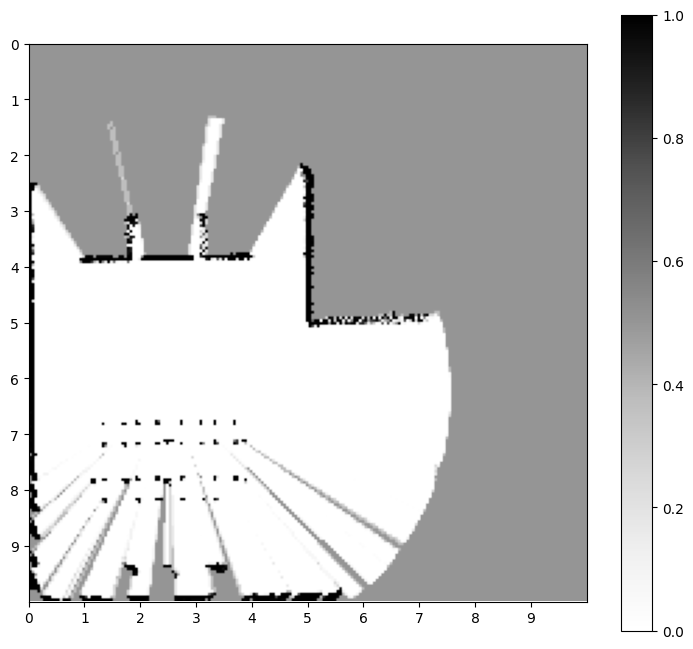

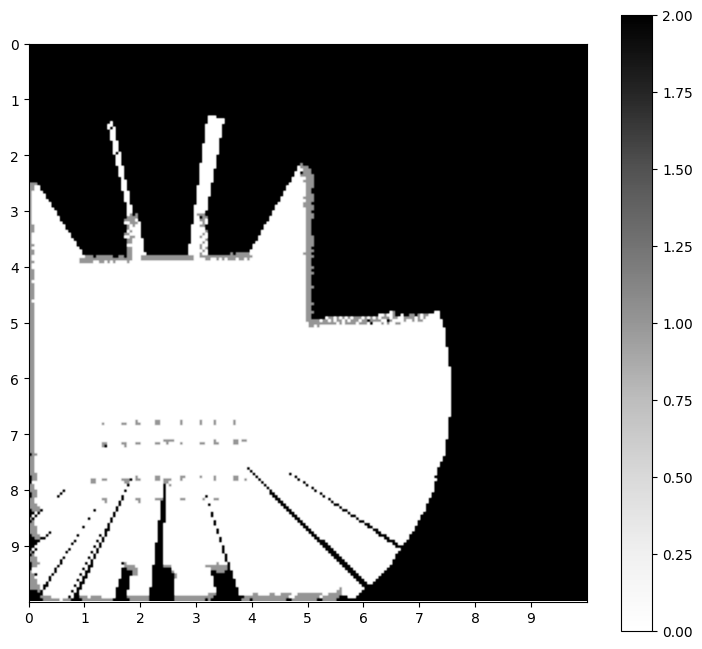

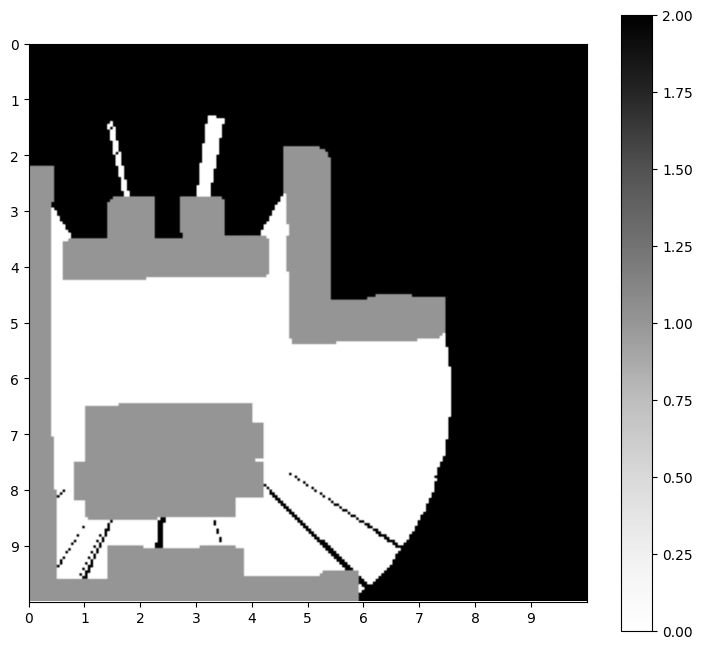

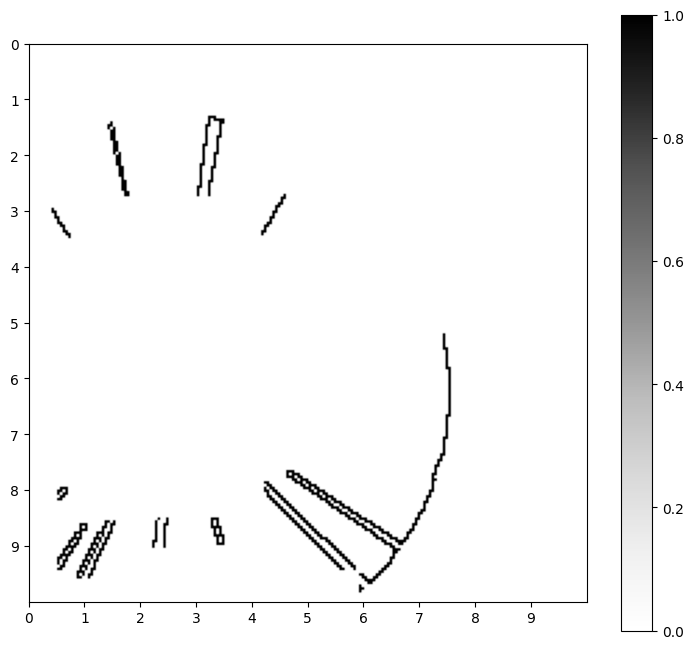

Exact path to goal not found. Returning path to the closest available point.


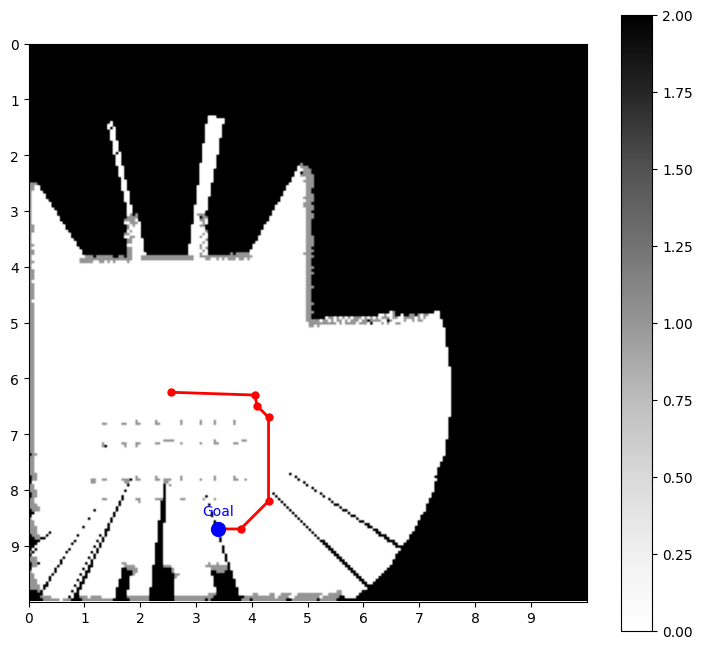

Arrived at a Frontier
Exploring!


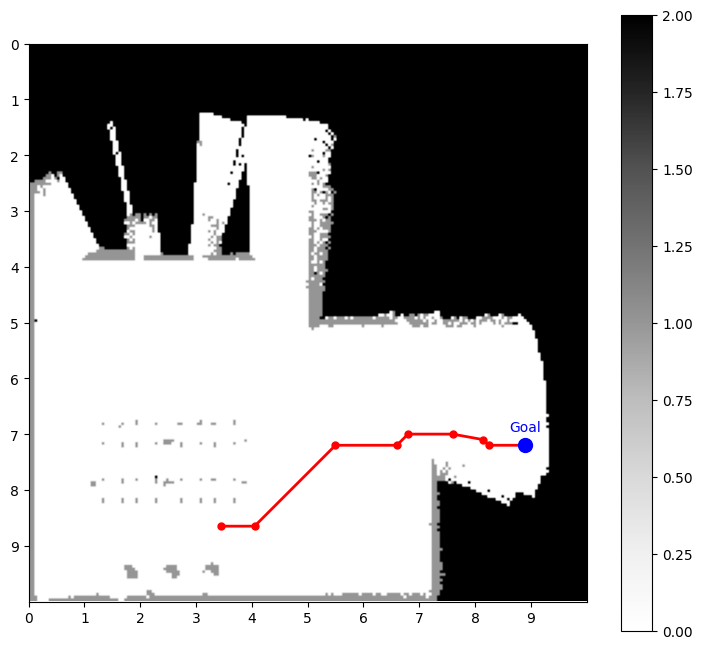

Arrived at a Frontier
Exploring!


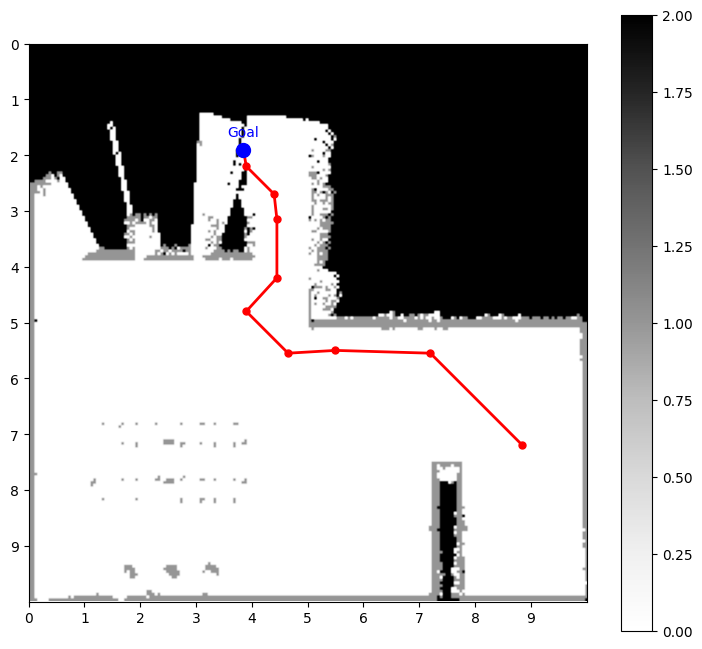

Arrived at a Frontier
Exploring!


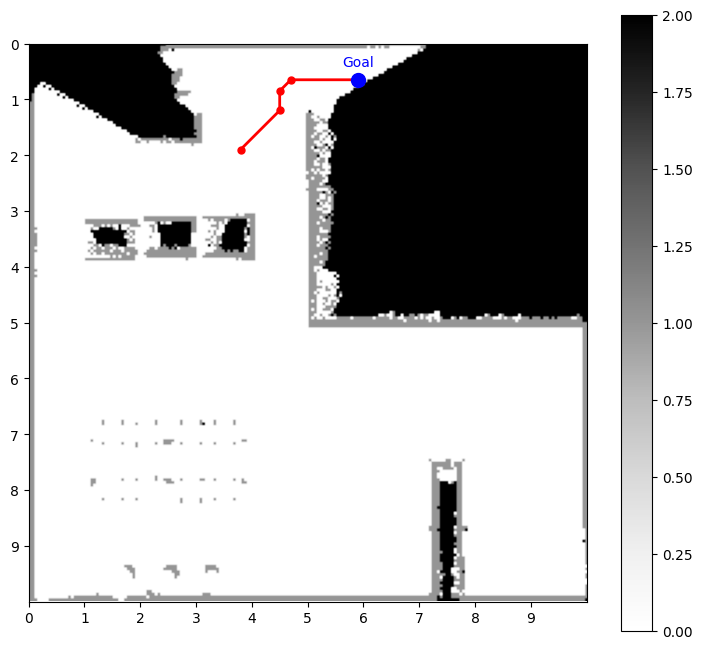

Arrived at a Frontier
Exploring!
Exact path to goal not found. Returning path to the closest available point.


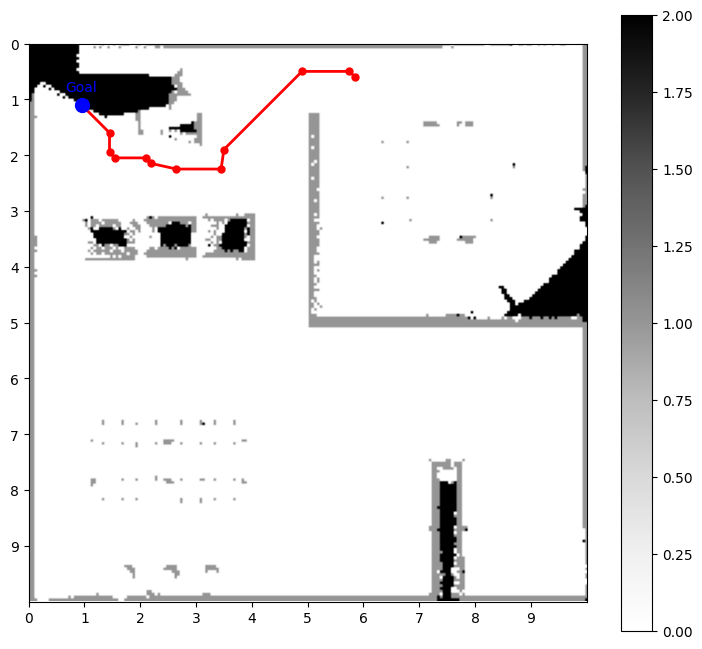

Arrived at a Frontier
Exploring!


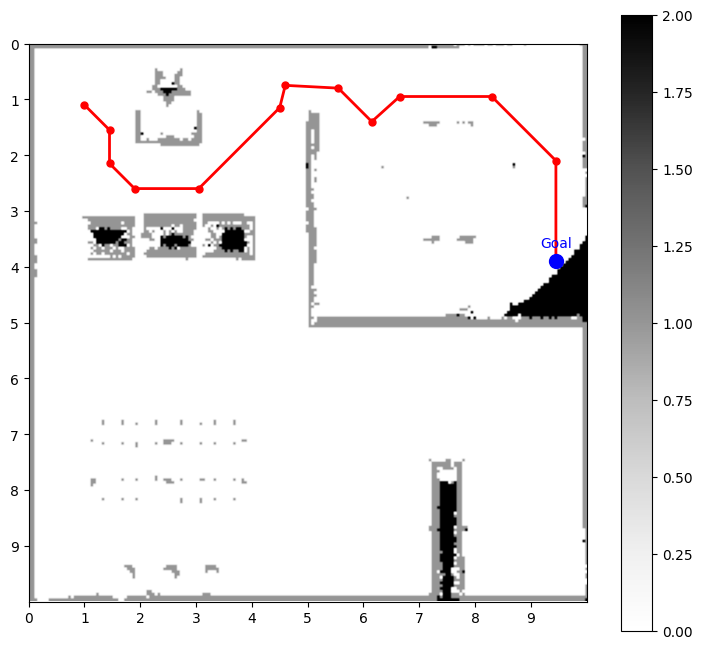

Arrived at a Frontier
Exploring!
No frontier left with size big enought
End of exploring :(, No other big enought frontier left


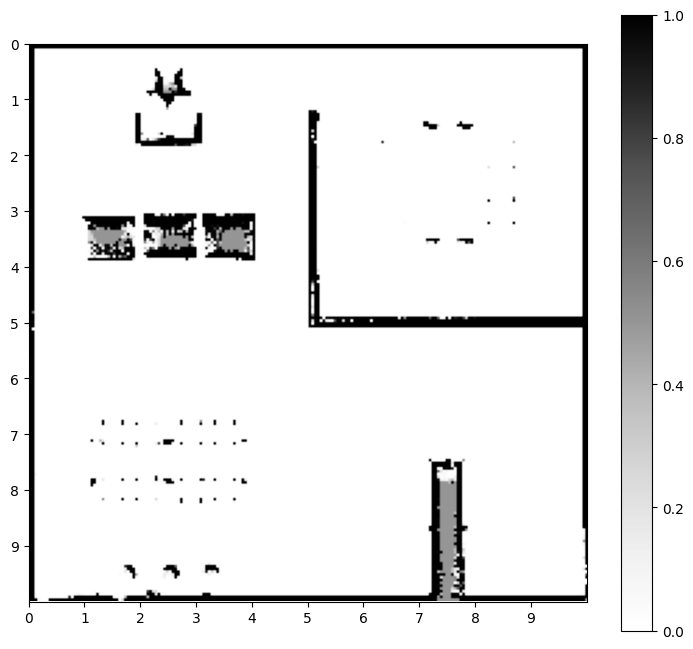

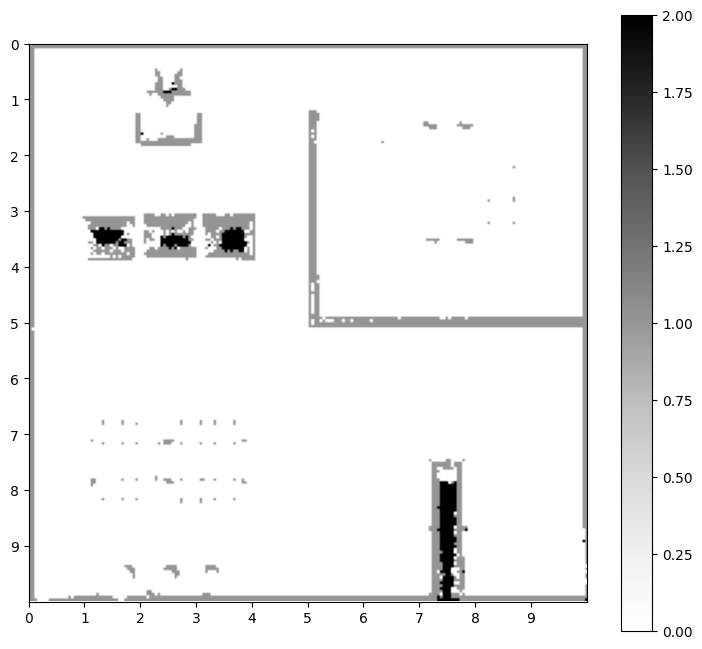

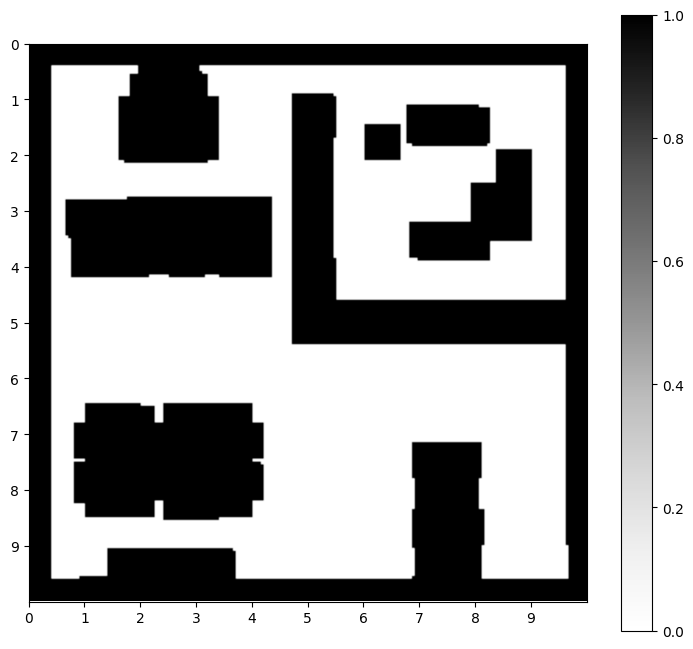

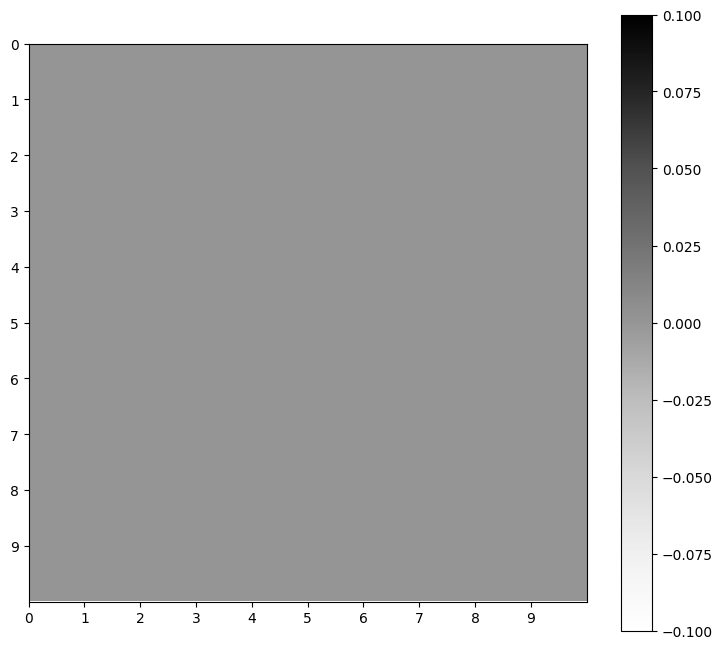

In [29]:
kobuki_handle = sim.getObject('/kobuki')
hokuyo_handle = sim.getObject('/fastHokuyo')
kobuki_left_motor = sim.getObject('/kobuki_leftMotor')
kobuki_right_motor = sim.getObject('/kobuki_rightMotor')


# Defining the variables the alter the comportament of the robot
velocity = 6
cell_size = 0.05
sensor_precision = 0.98
# The sensor noise variables and sensor limits can be changed on the 5th code cell
# inside the function sensor_processing_to_robot_coordinates(all set to 0)
# As for padding and frontier sizes and plot the path, you should visit 19th cell


Grid = OccupancyGrid(10, 10, cell_size, sensor_precision, hokuyo_handle, kobuki_handle, 
                     kobuki_left_motor, kobuki_right_motor, velocity)

sim.startSimulation()

rotate_360(kobuki_left_motor, kobuki_right_motor, kobuki_handle, velocity)

Grid.plot_grid_var(probability_grid_plot = True, reduced_grid_plot = True,
                   padded_grid_plot = True, frontiers_grid_plot = True)

while (find_path_to_explore(Grid.get_grid(), kobuki_left_motor, kobuki_right_motor,
                          kobuki_handle, velocity, cell_size) != 1):

    print("Exploring!")

print("End of exploring :(, No other big enought frontier left") 

sim.stopSimulation()

# Plots wanted shoud be marked as True
Grid.plot_grid_var(probability_grid_plot = True, reduced_grid_plot = True,
                   padded_grid_plot = True, frontiers_grid_plot = True)